In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import warnings
warnings.filterwarnings('ignore')

# 한글 폰트 설정
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.rcParams['axes.unicode_minus'] = False

print("라이브러리 import 완료")


라이브러리 import 완료


In [7]:
data = pd.read_csv('/Users/aaron/Downloads/cancel_gig_v2.csv')

df = pd.DataFrame(data)
print(f"데이터 형태: {df.shape}")
print("\n데이터 미리보기:")
df.head()

# 특정 gig_id 제외 (620975)
print(f"제외 전 데이터 수: {len(df)}")
df = df[df['gig_id'] != 620975]
print(f"제외 후 데이터 수: {len(df)}")
print(f"제외된 gig_id 620975")

데이터 형태: (149, 9)

데이터 미리보기:
제외 전 데이터 수: 149
제외 후 데이터 수: 148
제외된 gig_id 620975


In [8]:
# 데이터 전처리: 퍼센트 문자열을 숫자로 변환
def clean_percentage(value):
    """퍼센트 문자열을 숫자로 변환"""
    if isinstance(value, str):
        return float(value.replace('%', ''))/100.0
    return value

# 퍼센트 컬럼들을 숫자로 변환
percent_columns = ['cancel_rate', 'cancel_rate_3m', 'cancel_rate_chnage_by_avg', 'cancel_rate_change_by_3m']

for col in percent_columns:
    df[col] = df[col].apply(clean_percentage)

print("데이터 전처리 완료")
print("\n전처리된 데이터:")
df.head()


데이터 전처리 완료

전처리된 데이터:


,gig_id,gig_category_1_id,seller_rating,order_count,cancel_count,cancel_rate,cancel_rate_3m,cancel_rate_chnage_by_avg,cancel_rate_change_by_3m
1,592778,1,MASTER,35,7,0.200,0.104,3.000,0.927
2,315263,12,MASTER,46,7,0.152,0.130,1.174,0.172
3,645489,2,MASTER,39,6,0.154,0.092,2.077,0.668
4,96346,2,NEW,53,6,0.113,0.109,1.264,0.041
5,80627,2,MASTER,51,6,0.118,0.126,1.353,-0.063


데이터 기본 정보:
<class 'pandas.core.frame.DataFrame'>
Index: 148 entries, 1 to 148
Data columns (total 9 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   gig_id                     148 non-null    int64  
 1   gig_category_1_id          148 non-null    int64  
 2   seller_rating              148 non-null    object 
 3   order_count                148 non-null    int64  
 4   cancel_count               148 non-null    int64  
 5   cancel_rate                148 non-null    float64
 6   cancel_rate_3m             148 non-null    float64
 7   cancel_rate_chnage_by_avg  148 non-null    float64
 8   cancel_rate_change_by_3m   148 non-null    float64
dtypes: float64(4), int64(4), object(1)
memory usage: 11.6+ KB
None

기술 통계:
              gig_id  gig_category_1_id  order_count  cancel_count  \
count     148.000000         148.000000   148.000000    148.000000   
mean   459217.824324           5.472973    10.878378      

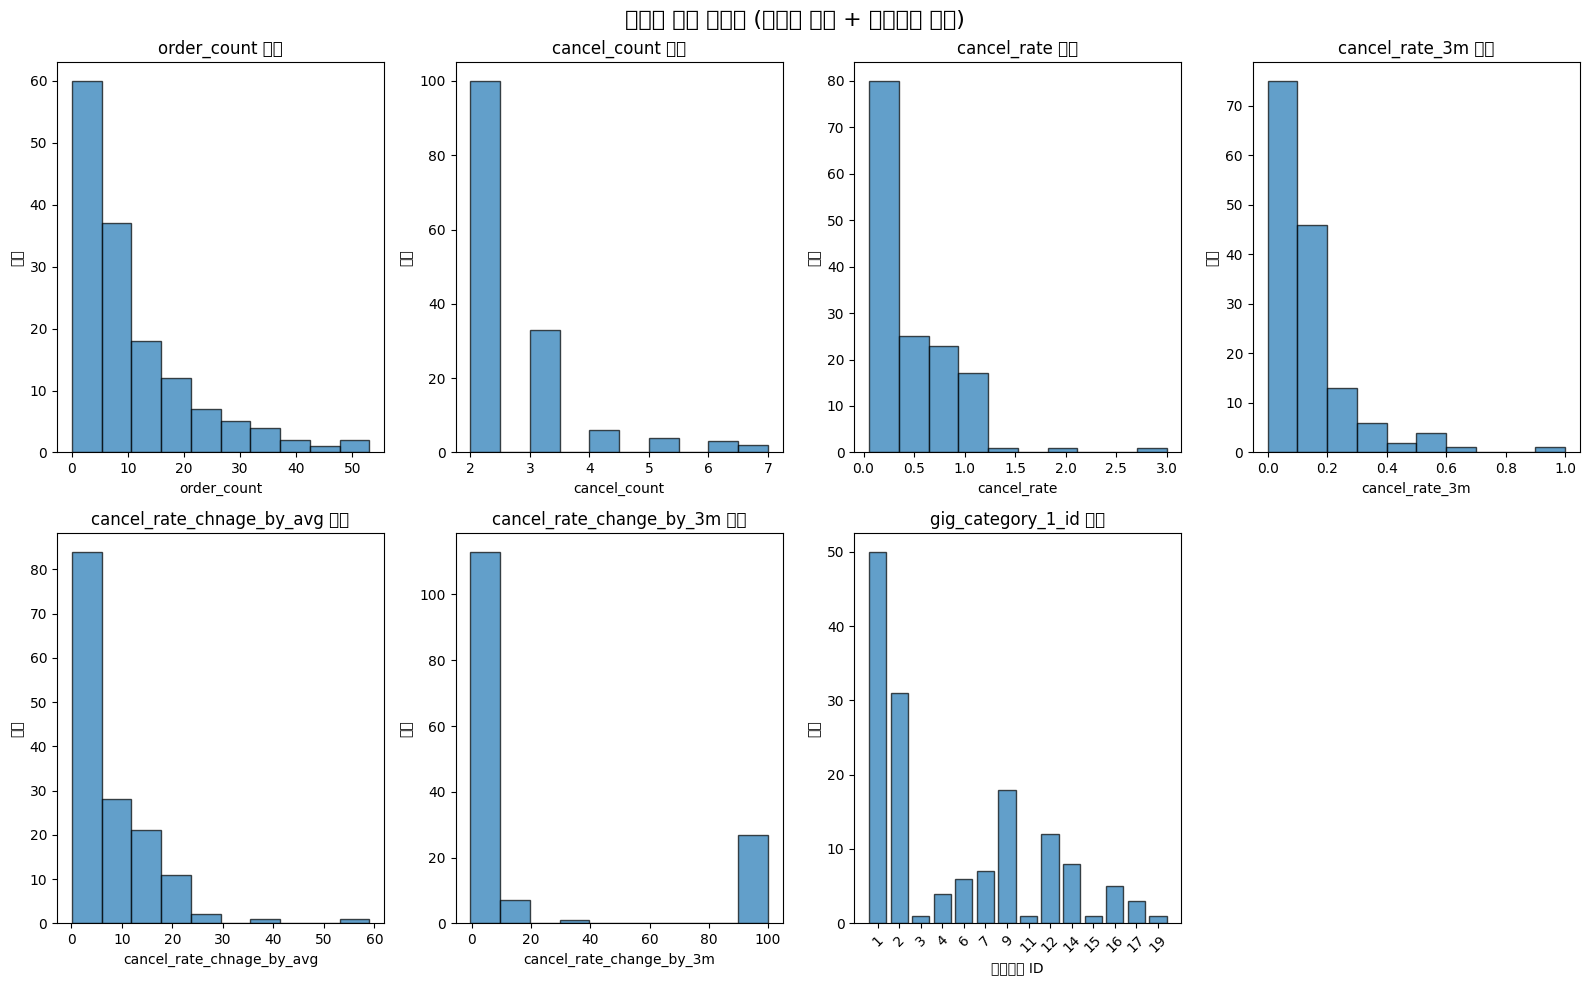

In [12]:
# 데이터 탐색 및 통계 정보
print("데이터 기본 정보:")
print(df.info())
print("\n기술 통계:")
print(df.describe())

# 데이터 분포 시각화
fig, axes = plt.subplots(2, 4, figsize=(16, 10))
fig.suptitle('데이터 분포 시각화 (수치형 특성 + 카테고리 분포)', fontsize=16)

# 수치형 컬럼들과 카테고리 컬럼 선택
numeric_columns = ['order_count', 'cancel_count', 'cancel_rate', 'cancel_rate_3m', 
                   'cancel_rate_chnage_by_avg', 'cancel_rate_change_by_3m']
categorical_column = 'gig_category_1_id'

# 수치형 특성들 시각화
for i, col in enumerate(numeric_columns):
    row = i // 4
    col_idx = i % 4
    axes[row, col_idx].hist(df[col], bins=10, alpha=0.7, edgecolor='black')
    axes[row, col_idx].set_title(f'{col} 분포')
    axes[row, col_idx].set_xlabel(col)
    axes[row, col_idx].set_ylabel('빈도')

# 카테고리 분포 시각화 (마지막 subplot)
category_counts = df[categorical_column].value_counts().sort_index()
axes[1, 2].bar(category_counts.index.astype(str), category_counts.values, alpha=0.7, edgecolor='black')
axes[1, 2].set_title(f'{categorical_column} 분포')
axes[1, 2].set_xlabel('카테고리 ID')
axes[1, 2].set_ylabel('빈도')
axes[1, 2].tick_params(axis='x', rotation=45)

# 마지막 subplot 숨기기
axes[1, 3].set_visible(False)

plt.tight_layout()
plt.show()


In [13]:
# 클러스터링을 위한 특성 선택 및 전처리
# gig_id는 식별자이므로 제외, seller_rating은 범주형이므로 제외

# 먼저 gig_category_1_id의 분포 확인
print("gig_category_1_id 분포:")
print(df['gig_category_1_id'].value_counts().sort_index())
print(f"\n고유 카테고리 수: {df['gig_category_1_id'].nunique()}개")

# gig_category_1_id를 원-핫 인코딩
from sklearn.preprocessing import LabelEncoder
import pandas as pd

# 카테고리를 원-핫 인코딩으로 변환
category_encoded = pd.get_dummies(df['gig_category_1_id'], prefix='category')
print(f"\n원-핫 인코딩 결과: {category_encoded.shape[1]}개 카테고리 특성")
print("인코딩된 카테고리 컬럼들:")
print(category_encoded.columns.tolist())

# 수치형 특성들
numeric_features = ['order_count', 'cancel_count', 'cancel_rate', 'cancel_rate_3m', 
                   'cancel_rate_chnage_by_avg', 'cancel_rate_change_by_3m']

# 수치형 특성과 인코딩된 카테고리 특성 결합
X_numeric = df[numeric_features].copy()
X = pd.concat([category_encoded, X_numeric], axis=1)

print(f"\n최종 특성 데이터 형태: {X.shape}")
print("클러스터링에 사용할 특성:")
print(X.head())

# 특성 이름 업데이트
features = X.columns.tolist()

# 데이터 표준화 (K-means는 거리 기반이므로 표준화가 중요)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print(f"\n표준화된 데이터 형태: {X_scaled.shape}")
print("표준화된 데이터 샘플:")
print(X_scaled[:3])
print(f"\n사용된 특성 수: {len(features)}개")
print(f"특성 목록: {features[:5]}... (총 {len(features)}개)")


gig_category_1_id 분포:
gig_category_1_id
1     50
2     31
3      1
4      4
6      6
7      7
9     18
11     1
12    12
14     8
15     1
16     5
17     3
19     1
Name: count, dtype: int64

고유 카테고리 수: 14개

원-핫 인코딩 결과: 14개 카테고리 특성
인코딩된 카테고리 컬럼들:
['category_1', 'category_2', 'category_3', 'category_4', 'category_6', 'category_7', 'category_9', 'category_11', 'category_12', 'category_14', 'category_15', 'category_16', 'category_17', 'category_19']

최종 특성 데이터 형태: (148, 20)
클러스터링에 사용할 특성:
   category_1  category_2  category_3  category_4  category_6  category_7  \
1        True       False       False       False       False       False   
2       False       False       False       False       False       False   
3       False        True       False       False       False       False   
4       False        True       False       False       False       False   
5       False        True       False       False       False       False   

   category_9  category_11  category_12  cate

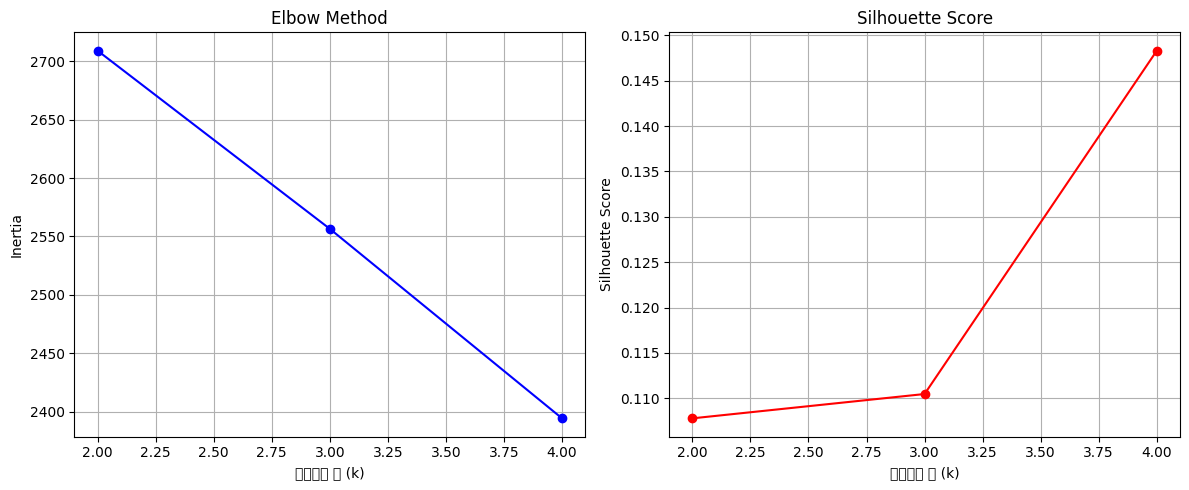

클러스터 수별 성능:
k=2: Inertia=2709.06, Silhouette Score=0.108
k=3: Inertia=2556.48, Silhouette Score=0.110
k=4: Inertia=2394.15, Silhouette Score=0.148


In [17]:
# 최적 클러스터 수 찾기 (Elbow Method)
# 데이터가 적으므로 2-3개 클러스터로 제한
k_range = range(2, min(5, len(df)))  # 최대 4개까지
inertias = []
silhouette_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=10)
    kmeans.fit(X_scaled)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_scaled, kmeans.labels_))

# Elbow Method 시각화
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(k_range, inertias, 'bo-')
ax1.set_xlabel('클러스터 수 (k)')
ax1.set_ylabel('Inertia')
ax1.set_title('Elbow Method')
ax1.grid(True)

ax2.plot(k_range, silhouette_scores, 'ro-')
ax2.set_xlabel('클러스터 수 (k)')
ax2.set_ylabel('Silhouette Score')
ax2.set_title('Silhouette Score')
ax2.grid(True)

plt.tight_layout()
plt.show()

print("클러스터 수별 성능:")
for k, inertia, sil_score in zip(k_range, inertias, silhouette_scores):
    print(f"k={k}: Inertia={inertia:.2f}, Silhouette Score={sil_score:.3f}")


In [19]:
# 최적 클러스터 수로 K-means 수행
# Silhouette Score가 가장 높은 k 선택
best_k = k_range[np.argmax(silhouette_scores)]
print(f"최적 클러스터 수: {best_k}")

# K-means 클러스터링 수행
kmeans = KMeans(n_clusters=best_k, random_state=42, n_init=10)
cluster_labels = kmeans.fit_predict(X_scaled)

# 결과를 데이터프레임에 추가
df['cluster'] = cluster_labels

print(f"\n클러스터링 완료!")
print(f"각 클러스터별 데이터 수:")
print(df['cluster'].value_counts().sort_index())

print(f"\n클러스터링 결과:")
# 원본 데이터의 수치형 특성들과 카테고리 특성을 함께 표시
display_features = ['gig_category_1_id', 'order_count', 'cancel_count', 'cancel_rate', 'cancel_rate_3m', 
                   'cancel_rate_chnage_by_avg', 'cancel_rate_change_by_3m']
print(df[['gig_id', 'cluster'] + display_features].sort_values('cluster'))


최적 클러스터 수: 4

클러스터링 완료!
각 클러스터별 데이터 수:
cluster
0    43
1    99
2     1
3     5
Name: count, dtype: int64

클러스터링 결과:
     gig_id  cluster  gig_category_1_id  order_count  cancel_count  \
16   685633        0                  1            4             3   
10   692850        0                 14            7             4   
20   170444        0                  1            3             3   
26   411216        0                  1            0             3   
25   419257        0                 11            2             3   
..      ...      ...                ...          ...           ...   
61   634125        3                 16            2             2   
123  383779        3                 16            4             2   
117  509549        3                 16            5             2   
59   607899        3                 16            2             2   
146  413190        3                 16            5             2   

     cancel_rate  cancel_rate_3m  cancel_ra

In [20]:
# 클러스터별 특성 분석 (수치형 특성들만)
numeric_features_analysis = ['order_count', 'cancel_count', 'cancel_rate', 'cancel_rate_3m', 
                            'cancel_rate_chnage_by_avg', 'cancel_rate_change_by_3m']

print("클러스터별 수치형 특성 평균값:")
cluster_means = df.groupby('cluster')[numeric_features_analysis].mean()
print(cluster_means.round(2))

print("\n클러스터별 카테고리 분포:")
category_cluster_dist = pd.crosstab(df['cluster'], df['gig_category_1_id'])
print(category_cluster_dist)

print("\n클러스터별 특성 해석:")
for cluster_id in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster_id]
    print(f"\n클러스터 {cluster_id} ({len(cluster_data)}개 데이터):")
    print(f"  - 평균 주문 수: {cluster_data['order_count'].mean():.1f}")
    print(f"  - 평균 취소 수: {cluster_data['cancel_count'].mean():.1f}")
    print(f"  - 평균 취소율: {cluster_data['cancel_rate'].mean():.1f}%")
    print(f"  - 평균 3개월 취소율: {cluster_data['cancel_rate_3m'].mean():.1f}%")
    print(f"  - 평균 취소율 변화(평균 대비): {cluster_data['cancel_rate_chnage_by_avg'].mean():.1f}%")
    print(f"  - 평균 취소율 변화(3개월 대비): {cluster_data['cancel_rate_change_by_3m'].mean():.1f}%")
    
    # 주요 카테고리 표시
    top_categories = cluster_data['gig_category_1_id'].value_counts().head(3)
    print(f"  - 주요 카테고리: {', '.join([f'{cat}({count}개)' for cat, count in top_categories.items()])}")


클러스터별 수치형 특성 평균값:
         order_count  cancel_count  cancel_rate  cancel_rate_3m  \
cluster                                                           
0               3.05          2.19         0.84            0.08   
1              14.65          2.71         0.27            0.14   
2              11.00          3.00         0.27            0.03   
3               3.60          2.00         0.66            0.22   

         cancel_rate_chnage_by_avg  cancel_rate_change_by_3m  
cluster                                                       
0                            14.93                     55.20  
1                             4.10                      4.94  
2                            26.27                      8.00  
3                             2.30                     40.27  

클러스터별 카테고리 분포:
gig_category_1_id  1   2   3   4   6   7   9   11  12  14  15  16  17  19
cluster                                                                  
0                  21   4   0   2   2

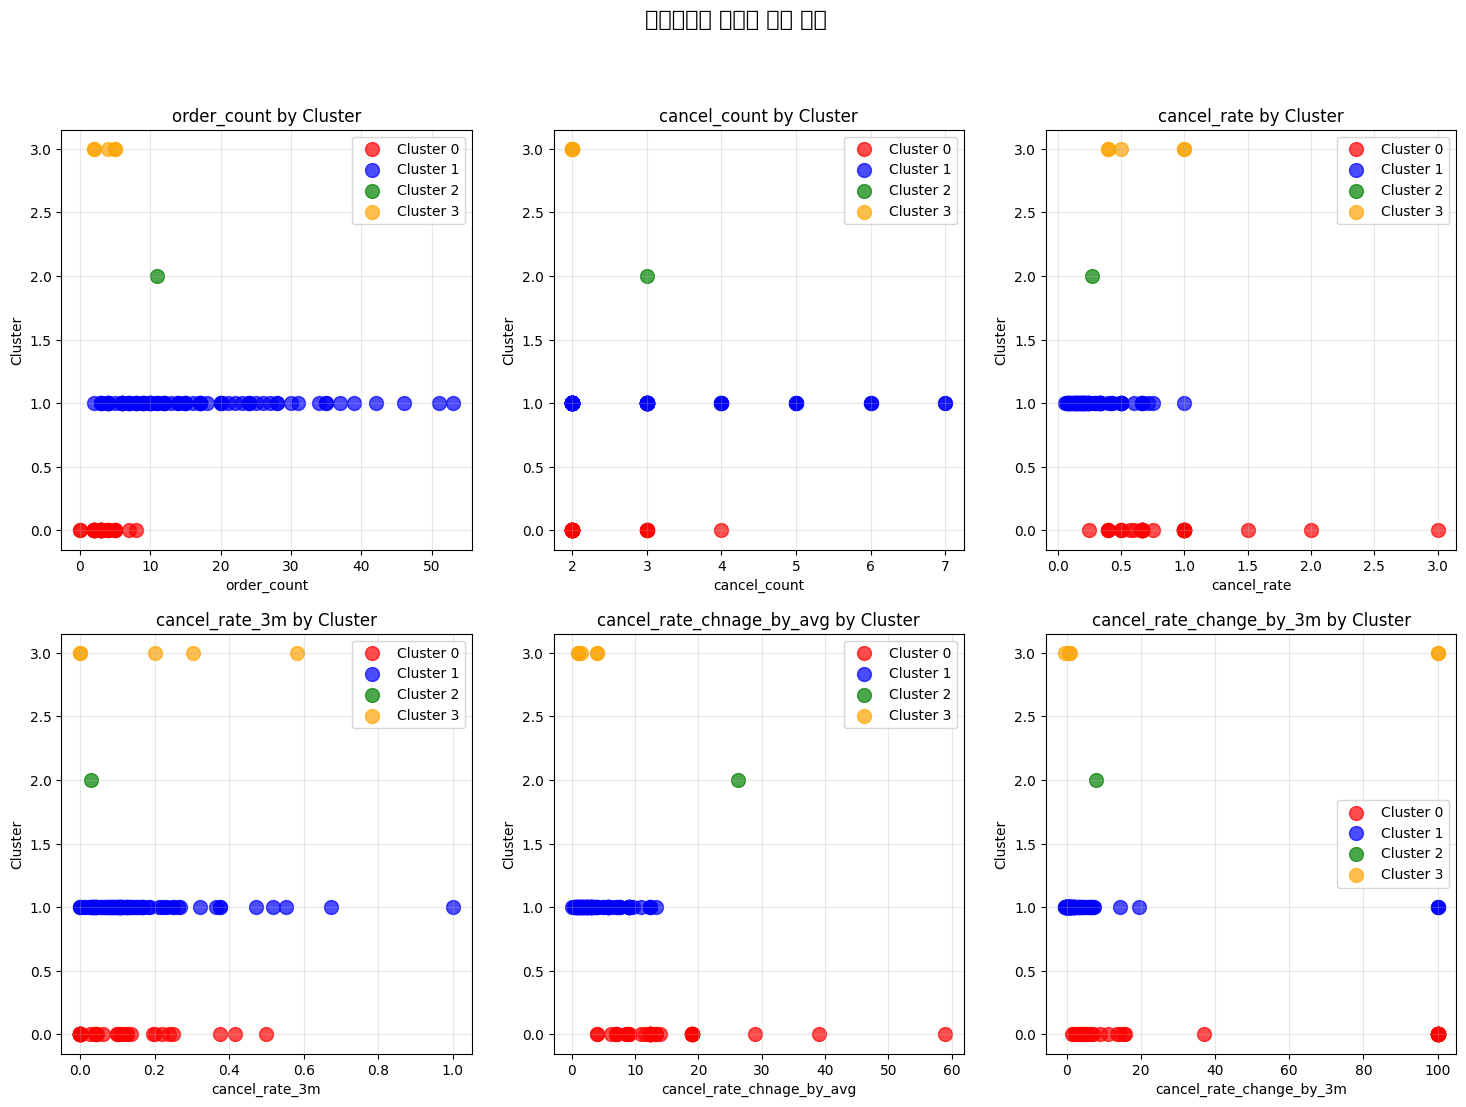

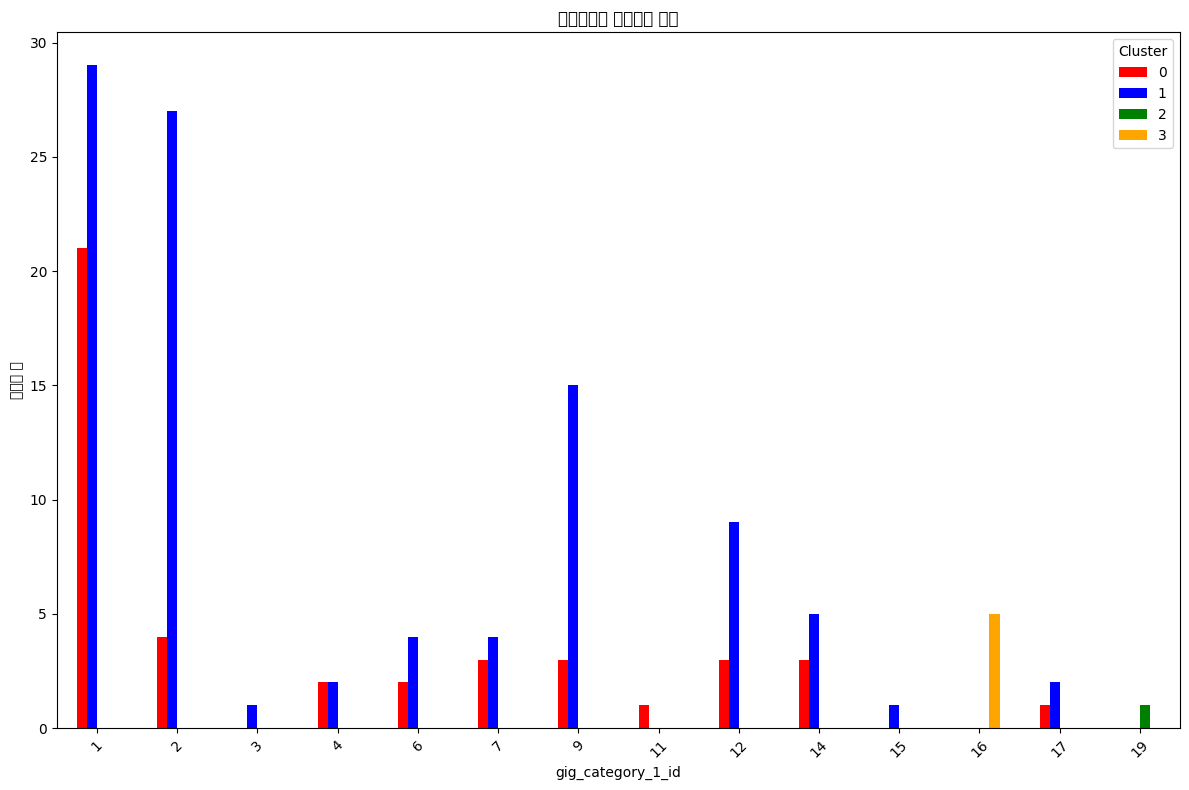

In [21]:
# 클러스터링 결과 시각화 (수치형 특성들만)
numeric_features_for_viz = ['order_count', 'cancel_count', 'cancel_rate', 'cancel_rate_3m', 
                           'cancel_rate_chnage_by_avg', 'cancel_rate_change_by_3m']

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
fig.suptitle('클러스터별 수치형 특성 분포', fontsize=16)

colors = ['red', 'blue', 'green', 'orange', 'purple']

for i, feature in enumerate(numeric_features_for_viz):
    row = i // 3
    col = i % 3
    
    for cluster_id in sorted(df['cluster'].unique()):
        cluster_data = df[df['cluster'] == cluster_id]
        axes[row, col].scatter(cluster_data[feature], 
                              [cluster_id] * len(cluster_data), 
                              c=colors[cluster_id], 
                              label=f'Cluster {cluster_id}',
                              alpha=0.7, s=100)
    
    axes[row, col].set_xlabel(feature)
    axes[row, col].set_ylabel('Cluster')
    axes[row, col].set_title(f'{feature} by Cluster')
    axes[row, col].legend()
    axes[row, col].grid(True, alpha=0.3)

# 카테고리별 클러스터 분포 추가 시각화
fig2, ax = plt.subplots(1, 1, figsize=(12, 8))
category_cluster = pd.crosstab(df['gig_category_1_id'], df['cluster'])
category_cluster.plot(kind='bar', ax=ax, color=colors[:len(df['cluster'].unique())])
ax.set_title('카테고리별 클러스터 분포')
ax.set_xlabel('gig_category_1_id')
ax.set_ylabel('데이터 수')
ax.legend(title='Cluster')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()


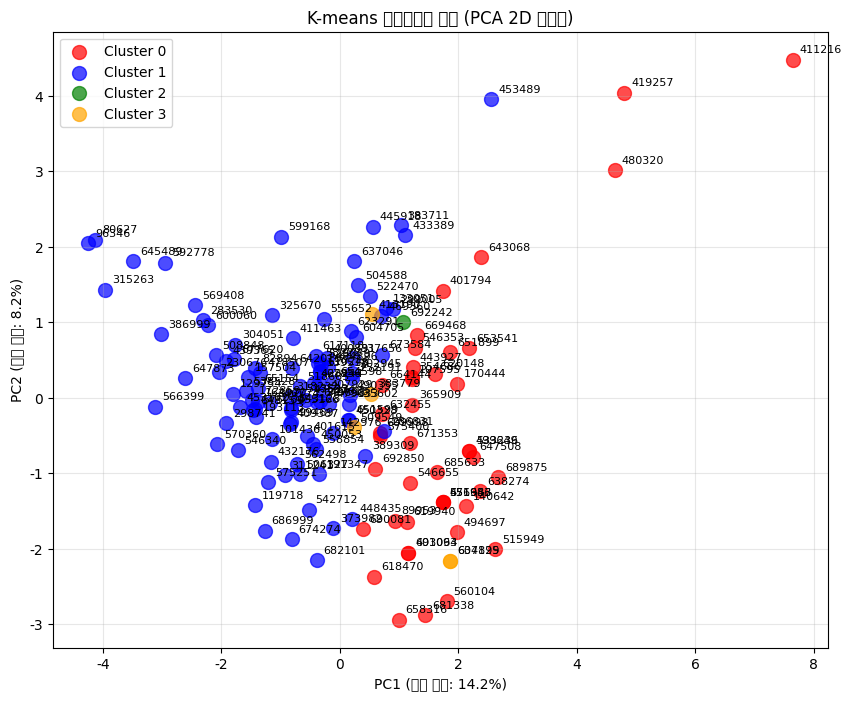

PCA 설명 분산 비율: [0.14244445 0.08184744]
총 설명 분산: 22.4%


In [22]:
# PCA를 사용한 2D 시각화 (7차원 데이터를 2차원으로 축소)
from sklearn.decomposition import PCA

# PCA 적용
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)

# PCA 결과 시각화
plt.figure(figsize=(10, 8))
colors = ['red', 'blue', 'green', 'orange', 'purple']

for cluster_id in sorted(df['cluster'].unique()):
    cluster_mask = df['cluster'] == cluster_id
    plt.scatter(X_pca[cluster_mask, 0], X_pca[cluster_mask, 1], 
               c=colors[cluster_id], label=f'Cluster {cluster_id}', 
               alpha=0.7, s=100)

plt.xlabel(f'PC1 (설명 분산: {pca.explained_variance_ratio_[0]:.1%})')
plt.ylabel(f'PC2 (설명 분산: {pca.explained_variance_ratio_[1]:.1%})')
plt.title('K-means 클러스터링 결과 (PCA 2D 시각화)')
plt.legend()
plt.grid(True, alpha=0.3)

# 각 점에 gig_id 표시
for i, gig_id in enumerate(df['gig_id']):
    plt.annotate(str(gig_id), (X_pca[i, 0], X_pca[i, 1]), 
                xytext=(5, 5), textcoords='offset points', fontsize=8)

plt.show()

print(f"PCA 설명 분산 비율: {pca.explained_variance_ratio_}")
print(f"총 설명 분산: {pca.explained_variance_ratio_.sum():.1%}")


In [23]:
# 최종 결과 요약
print("="*60)
print("K-means 클러스터링 결과 요약")
print("="*60)

print(f"데이터 수: {len(df)}개")
print(f"사용된 특성 개수: {len(features)}개")
print(f"  - 원-핫 인코딩된 카테고리 특성: {len([f for f in features if f.startswith('category_')])}개")
print(f"  - 수치형 특성: {len([f for f in features if not f.startswith('category_')])}개")
print(f"원본 특성: gig_category_1_id(원-핫 인코딩), order_count, cancel_count, cancel_rate, cancel_rate_3m, cancel_rate_chnage_by_avg, cancel_rate_change_by_3m")
print(f"최적 클러스터 수: {best_k}개")
print(f"Silhouette Score: {silhouette_score(X_scaled, cluster_labels):.3f}")

print(f"\n클러스터별 상세 정보:")
for cluster_id in sorted(df['cluster'].unique()):
    cluster_data = df[df['cluster'] == cluster_id]
    print(f"\n[클러스터 {cluster_id}] - {len(cluster_data)}개 데이터")
    print(f"  Gig IDs: {', '.join(map(str, cluster_data['gig_id'].tolist()))}")
    
    # 클러스터 특성 요약
    if cluster_data['order_count'].mean() > df['order_count'].mean():
        order_status = "높음"
    else:
        order_status = "낮음"
    
    if cluster_data['cancel_rate'].mean() > df['cancel_rate'].mean():
        cancel_status = "높음"
    else:
        cancel_status = "낮음"
    
    print(f"  특성: 주문량 {order_status}, 취소율 {cancel_status}")

print(f"\n클러스터링이 완료되었습니다!")
print(f"실제 CSV 파일을 사용하려면 첫 번째 셀의 데이터 생성 부분을")
print(f"df = pd.read_csv('your_file.csv')로 변경하세요.")


K-means 클러스터링 결과 요약
데이터 수: 148개
사용된 특성 개수: 20개
  - 원-핫 인코딩된 카테고리 특성: 14개
  - 수치형 특성: 6개
원본 특성: gig_category_1_id(원-핫 인코딩), order_count, cancel_count, cancel_rate, cancel_rate_3m, cancel_rate_chnage_by_avg, cancel_rate_change_by_3m
최적 클러스터 수: 4개
Silhouette Score: 0.148

클러스터별 상세 정보:

[클러스터 0] - 43개 데이터
  Gig IDs: 692850, 685633, 546655, 170444, 651899, 419257, 411216, 551946, 658316, 89953, 690081, 681338, 638274, 493064, 533236, 140642, 689875, 560104, 451683, 499649, 601093, 515949, 494697, 676953, 619940, 618470, 575400, 365909, 609998, 632455, 647508, 653541, 107595, 354686, 480320, 671353, 443927, 401794, 664144, 620148, 546353, 669468, 643068
  특성: 주문량 낮음, 취소율 높음

[클러스터 1] - 99개 데이터
  Gig IDs: 592778, 315263, 645489, 96346, 80627, 569408, 637046, 386999, 599168, 119718, 617118, 648159, 508848, 283530, 686999, 391347, 65154, 407929, 318232, 82894, 389309, 409387, 566399, 346774, 133051, 400891, 58222, 469360, 623291, 453102, 642010, 522470, 478507, 304051, 575260, 538528, 504588, 3